Step 1: Required Python Libraries

In [92]:
# Core LangGraph libraries
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
# LangChain tools and messages
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda
from langchain_core.runnables.history import RunnableWithMessageHistory
# Pydantic for defining state
from pydantic import BaseModel, Field
# For typing and dictionaries
from typing import Dict, List, Optional, Union
# LangChain LLM (Groq with Mixtral or LLaMA3 etc.)
from langchain_groq import ChatGroq
# Memory store for message history (can be in-memory)
from langchain_community.chat_message_histories import FileChatMessageHistory
import os
from dotenv import load_dotenv


In [93]:
# Load environment variables
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")

In [94]:
# ================
# IMPORTS SECTION 
# ================
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage
from pydantic import BaseModel
from typing import Dict
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

# ==================
# INITIALIZATION 
# ==================
load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Initialize LLM (replace with your actual initialization)
llm = ChatGroq(temperature=0.7, model_name="llama-3.1-8b-instant")



In [95]:
# ==================
# STATE DEFINITION
# ==================
class SupervisorState(BaseModel):
    current_agent: str                     
    task: str                              
    task_assignment: Dict[str, str] = {}   
    research_data: str = ""                
    analysis: str = ""                     
    report: str = ""                       
    summary: str = ""                      
    research_complete: bool = False  # Critical fix - added completion flag



In [96]:
# ==================
# AGENT FUNCTIONS
# ==================

def ceo_agent(state: SupervisorState) -> SupervisorState:
    """CEO agent that initiates the workflow"""
    response = llm.invoke([
        HumanMessage(content=f"Break down this task: {state.task}")
    ])
    state.task_assignment["Research Team Leader"] = response.content
    state.current_agent = "research_team_leader"
    return state

def research_team_leader_agent(state: SupervisorState) -> SupervisorState:
    """Coordinates research tasks"""
    if state.research_complete:  # Fix: Check completion status
        state.current_agent = "writing_team_leader"
        return state
        
    task = state.task_assignment["Research Team Leader"]
    response = llm.invoke([
        HumanMessage(content=f"Divide research: {task}")
    ])
    
    # Parse response into data and market tasks
    state.task_assignment["Data Researcher"] = f"Data task: {response.content}"
    state.task_assignment["Market Researcher"] = f"Market task: {response.content}"
    state.current_agent = "data_researcher"
    return state

def data_researcher_agent(state: SupervisorState) -> SupervisorState:
    """Handles data collection"""
    response = llm.invoke([
        HumanMessage(content=state.task_assignment["Data Researcher"])
    ])
    state.research_data += f"\nData Findings:\n{response.content}"
    
    # Fix: Check if we have market research already
    if "Market Findings" in state.research_data:
        state.research_complete = True
        
    state.current_agent = "market_researcher"
    return state

def market_researcher_agent(state: SupervisorState) -> SupervisorState:
    """Handles market analysis"""
    response = llm.invoke([
        HumanMessage(content=state.task_assignment["Market Researcher"])
    ])
    state.research_data += f"\nMarket Findings:\n{response.content}"
    
    # Fix: Go directly to writer instead of research lead
    state.current_agent = "writing_team_leader"
    return state

def writing_team_leader_agent(state: SupervisorState) -> SupervisorState:
    """Coordinates report writing"""
    if not state.research_data:
        state.current_agent = END
        return state
        
    # Stronger conditional logic added as fix
    if "report" in state.task.lower():
        state.current_agent = "technical_writer"
    else:
        state.current_agent = "summary_writer"
    return state

def technical_writer_agent(state: SupervisorState) -> SupervisorState:
    """Generates technical report"""
    response = llm.invoke([
        HumanMessage(content=f"Write report about: {state.task}")
    ])
    state.report = response.content
    state.current_agent = END  # Fix: Direct to END instead of looping
    return state

def summary_writer_agent(state: SupervisorState) -> SupervisorState:
    """Generates executive summary"""
    response = llm.invoke([
        HumanMessage(content=f"Summarize: {state.task}")
    ])
    state.summary = response.content
    state.current_agent = END  # Fix: Direct to END instead of looping
    return state



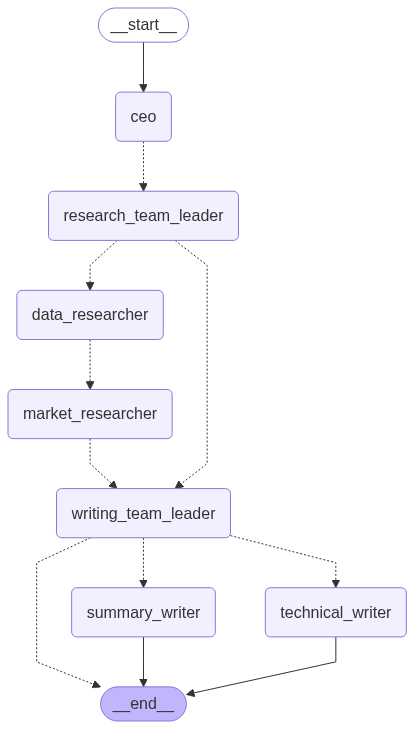

In [97]:
# ==================
# GRAPH CONSTRUCTION
# ==================
workflow = StateGraph(SupervisorState)

# Add all nodes
workflow.add_node("ceo", ceo_agent)
workflow.add_node("research_team_leader", research_team_leader_agent)
workflow.add_node("data_researcher", data_researcher_agent)
workflow.add_node("market_researcher", market_researcher_agent)
workflow.add_node("writing_team_leader", writing_team_leader_agent)
workflow.add_node("technical_writer", technical_writer_agent)
workflow.add_node("summary_writer", summary_writer_agent)

# Set entry point
workflow.set_entry_point("ceo")

# Add conditional edges
workflow.add_conditional_edges(
    "ceo",
    lambda state: state.current_agent,
    {"research_team_leader": "research_team_leader"}
)

workflow.add_conditional_edges(
    "research_team_leader",
    lambda state: state.current_agent,
    {
        "data_researcher": "data_researcher",
        "writing_team_leader": "writing_team_leader"
    }
)

workflow.add_conditional_edges(
    "data_researcher",
    lambda state: state.current_agent,
    {"market_researcher": "market_researcher"}
)

workflow.add_conditional_edges(
    "market_researcher",
    lambda state: state.current_agent,
    {"writing_team_leader": "writing_team_leader"}  # Fix: Direct to writer
)

workflow.add_conditional_edges(
    "writing_team_leader",
    lambda state: state.current_agent,
    {
        "technical_writer": "technical_writer",
        "summary_writer": "summary_writer",
        END: END
    }
)

# Terminating nodes don't need edges
workflow.add_edge("technical_writer", END)
workflow.add_edge("summary_writer", END)

# Compile the graph
app = workflow.compile()
app


In [98]:
# ==================
# EXECUTION
# ==================
response = app.invoke({
    "current_agent": "ceo",
    "task": "Analyze AI benefits and risks in healthcare and create report",
    "research_complete": False  # Initialize flag
})

print("Final Output:", response)


Final Output: {'current_agent': '__end__', 'task': 'Analyze AI benefits and risks in healthcare and create report', 'task_assignment': {'Research Team Leader': "**Task Breakdown: Analyze AI Benefits and Risks in Healthcare and Create Report**\n\n**Objective:** To conduct an in-depth analysis of the benefits and risks of Artificial Intelligence (AI) in the healthcare sector and create a comprehensive report.\n\n**Step 1: Research and Literature Review (Timeframe: 2-3 days)**\n\n1. Identify relevant studies, articles, and reports on AI applications in healthcare.\n2. Review existing literature on AI benefits and risks in healthcare, including:\n\t* Improved diagnosis accuracy\n\t* Enhanced patient outcomes\n\t* Streamlined clinical workflows\n\t* Data security concerns\n\t* Bias and fairness issues\n\t* Medical liability and regulatory challenges\n3. Note down key findings, insights, and gaps in existing research.\n\n**Step 2: Benefits of AI in Healthcare (Timeframe: 2-3 days)**\n\n1. Ca

## DETAILED  CODE 

In [180]:
from typing import Dict, Optional, Literal, List
from pydantic import BaseModel, Field
import os
from dotenv import load_dotenv
import time
from langchain_groq import ChatGroq
from datetime import datetime

# Load environment variables
load_dotenv()

# Initialize the language model
llm = ChatGroq(
    model_name="llama-3.1-8b-instant",
    temperature=0.7,
    api_key=os.getenv("GROQ_API_KEY")
)

class WorkflowState(BaseModel):
    current_stage: Literal[
        'ceo', 
        'research_lead',
        'data_researcher', 
        'market_researcher',
        'analyst',
        'writing_lead',
        'technical_writer',
        'summary_writer',
        '__end__'
    ] = 'ceo'
    
    user_input: str
    requirements: Dict[str, bool] = Field(
        default_factory=lambda: {
            'needs_data_research': False,
            'needs_market_research': False,
            'needs_technical_report': False,
            'needs_exec_summary': False
        }
    )
    research_data: Dict[str, Optional[str]] = Field(
        default_factory=lambda: {
            'data_findings': None,
            'market_findings': None
        }
    )
    analysis: Optional[str] = None
    deliverables: Dict[str, Optional[str]] = Field(
        default_factory=lambda: {
            'technical_report': None,
            'executive_summary': None
        }
    )

class WorkflowSystem:
    def __init__(self):
        self.llm = llm
    
    def query_llm(self, prompt: str) -> str:
        try:
            response = self.llm.invoke([{"role": "user", "content": prompt}])
            return response.content
        except Exception as e:
            print(f"LLM Error: {e}")
            return f"Error generating response: {str(e)}"

    def ceo_agent(self, state: WorkflowState) -> Dict:
        state.requirements = {
            'needs_data_research': any(x in state.user_input.lower() for x in ['data', 'statistics']),
            'needs_market_research': any(x in state.user_input.lower() for x in ['market', 'trends']),
            'needs_technical_report': 'report' in state.user_input.lower(),
            'needs_exec_summary': 'summary' in state.user_input.lower()
        }
        
        if state.requirements['needs_data_research'] or state.requirements['needs_market_research']:
            return {"current_stage": "research_lead"}
        return {"current_stage": "writing_lead"}
    
    def research_lead_agent(self, state: WorkflowState) -> Dict:
        if state.requirements['needs_data_research']:
            return {"current_stage": "data_researcher"}
        return {"current_stage": "market_researcher"}
    
    def data_researcher_agent(self, state: WorkflowState) -> Dict:
        prompt = f"""Generate comprehensive data research with statistics about: {state.user_input}.
        Include numerical data, trends over time, and authoritative sources when possible."""
        response = self.query_llm(prompt)
        state.research_data['data_findings'] = response
        
        if state.requirements['needs_market_research']:
            return {"current_stage": "market_researcher"}
        return {"current_stage": "analyst"}
    
    def market_researcher_agent(self, state: WorkflowState) -> Dict:
        prompt = f"""Analyze market conditions and industry trends for: {state.user_input}.
        Include competitor analysis, market size, growth projections, and SWOT analysis."""
        response = self.query_llm(prompt)
        state.research_data['market_findings'] = response
        return {"current_stage": "analyst"}
    
    def analyst_agent(self, state: WorkflowState) -> Dict:
        research_summary = ""
        if state.research_data['data_findings']:
            research_summary += f"Data Findings:\n{state.research_data['data_findings']}\n\n"
        if state.research_data['market_findings']:
            research_summary += f"Market Findings:\n{state.research_data['market_findings']}"
        
        prompt = f"""Synthesize this research into key insights:\n{research_summary}.
        Highlight 3-5 most important findings and their implications."""
        state.analysis = self.query_llm(prompt)
        return {"current_stage": "writing_lead"}
    
    def writing_lead_agent(self, state: WorkflowState) -> Dict:
        deliverables = []
        if state.requirements['needs_technical_report'] and not state.deliverables['technical_report']:
            deliverables.append("technical_writer")
        if state.requirements['needs_exec_summary'] and not state.deliverables['executive_summary']:
            deliverables.append("summary_writer")
        
        if not deliverables:
            return {"current_stage": "__end__"}
        return {"current_stage": deliverables[0]}
    
    def technical_writer_agent(self, state: WorkflowState) -> Dict:
        prompt = f"""Write a professional technical report about: {state.user_input}.
        Structure with: Executive Summary, Methodology, Findings, Analysis, and Conclusions.
        Include these findings:\n{state.analysis}"""
        state.deliverables['technical_report'] = self.query_llm(prompt)
        return {"current_stage": "writing_lead"}
    
    def summary_writer_agent(self, state: WorkflowState) -> Dict:
        prompt = f"""Create an executive summary about: {state.user_input}.
        Include: Key Findings, Recommendations, and Strategic Implications.
        Maximum 1 page. Use this analysis:\n{state.analysis}"""
        state.deliverables['executive_summary'] = self.query_llm(prompt)
        return {"current_stage": "writing_lead"}

    def writer_agent(self, state: WorkflowState) -> Dict:
        """Writer uses Groq to create final report"""
        
        research_data = f"Data Findings:\n{state.research_data['data_findings']}\n\nMarket Findings:\n{state.research_data['market_findings']}"
        analysis = state.analysis
        task = state.user_input
        
        # Create writing prompt
        writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
        
        # Get report from LLM
        report_response = self.query_llm(writing_prompt)
        report = report_response
        
        # Create final formatted report
        final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
        
        state.deliverables['final_report'] = final_report
        return {"current_stage": "__end__"}

def execute_workflow(user_input: str) -> Dict:
    system = WorkflowSystem()
    state = WorkflowState(user_input=user_input)
    
    agents = {
        'ceo': system.ceo_agent,
        'research_lead': system.research_lead_agent,
        'data_researcher': system.data_researcher_agent,
        'market_researcher': system.market_researcher_agent,
        'analyst': system.analyst_agent,
        'writing_lead': system.writing_lead_agent,
        'technical_writer': system.technical_writer_agent,
        'summary_writer': system.summary_writer_agent,
        'writer': system.writer_agent
    }
    
    while state.current_stage != '__end__':
        print(f"\n[{state.current_stage.upper()}] Processing...")
        agent = agents[state.current_stage]
        result = agent(state)
        state.current_stage = result["current_stage"]
        
        # Rate limiting to avoid API issues
        time.sleep(1)
    
    print("\nWorkflow completed successfully!")
    return {
        'analysis': state.analysis,
        'deliverables': {
            k: v for k, v in state.deliverables.items() 
            if v is not None
        }
    }

if __name__ == "__main__":
    # Example Usage
    print("===== TEST CASE 1 =====")
    results = execute_workflow(
        "Analyze AI in healthcare including data statistics and market trends. "
        "Provide technical report and executive summary."
    )
    print("\nFINAL OUTPUT:")
    for key, value in results.items():
        if isinstance(value, dict):
            print(f"\n{key.upper()}:")
            for sub_key, sub_value in value.items():
                print(f"\n{sub_key}:")
                print(sub_value)
        else:
            print(f"\n{key.upper()}:")
            print(value)


===== TEST CASE 1 =====

[CEO] Processing...

[RESEARCH_LEAD] Processing...

[DATA_RESEARCHER] Processing...

[MARKET_RESEARCHER] Processing...

[ANALYST] Processing...

[WRITING_LEAD] Processing...

[TECHNICAL_WRITER] Processing...

[WRITING_LEAD] Processing...

[SUMMARY_WRITER] Processing...

[WRITING_LEAD] Processing...

Workflow completed successfully!

FINAL OUTPUT:

ANALYSIS:
**Key Insights and Implications:**

1. **Rapid Growth of the AI in Healthcare Market**: The global AI in healthcare market is expected to grow from $2.1 billion in 2020 to $36.1 billion by 2025, at a Compound Annual Growth Rate (CAGR) of 59.9%. This rapid growth is driven by increasing demand for personalized medicine, improving patient outcomes, and reducing healthcare costs.

**Implication**: The AI in healthcare market is expected to become a significant player in the healthcare industry, driving innovation and growth. Companies that invest in AI research and development will be well-positioned to capital

In [193]:
if __name__ == "__main__":
    print("===== FINANCIAL MARKET ANALYSIS =====")
    results = execute_workflow(
        "Analyze blockchain adoption in financial markets including "
        "crypto transaction volume trends and regulatory impacts. "
        "Provide full technical documentation and bullet-point summary for executives."
    )
    
    print("\nFINAL OUTPUT:")
    
    # Safe analysis printing
    print(f"\nANALYSIS:")
    print(results.get('analysis', 'No analysis generated'))
    
    # Safe deliverables printing
    print("\nDELIVERABLES:")
    if 'deliverables' in results:
        print("\nTechnical Report:")
        print(results['deliverables'].get('technical_report', 'Not requested'))
        
        print("\nExecutive Summary:")
        print(results['deliverables'].get('executive_summary', 'Not requested'))
        

    else:
        print("No deliverables generated")


===== FINANCIAL MARKET ANALYSIS =====

[CEO] Processing...

[RESEARCH_LEAD] Processing...

[MARKET_RESEARCHER] Processing...

[ANALYST] Processing...

[WRITING_LEAD] Processing...

[SUMMARY_WRITER] Processing...

[WRITING_LEAD] Processing...

Workflow completed successfully!

FINAL OUTPUT:

ANALYSIS:
Here are the 3-5 most important findings and their implications:

1. **Rapid Market Growth**: The blockchain adoption in financial markets is expected to reach $39.7 billion by 2025, growing at a CAGR of 67.1%. This rapid growth indicates a significant increase in demand for secure, transparent, and efficient financial transactions.

Implication: As the market grows, more businesses and investors will be attracted to the space, driving innovation and adoption.

2. **Regulatory Uncertainty**: The SEC's lawsuit against Ripple and increasing regulatory scrutiny in countries like China and India pose significant threats to the industry's growth. Regulatory uncertainty can lead to market volati

In [192]:
def writer_agent(self, state: WorkflowState) -> Dict:
    """Writer uses Groq to create final report"""
    
    research_data = f"Data Findings:\n{state.research_data['data_findings']}\n\nMarket Findings:\n{state.research_data['market_findings']}"
    analysis = state.analysis
    task = state.user_input
    
    # Create writing prompt
    writing_prompt = f"""As a professional writer, create an executive report based on:

Task: {task}

Research Findings:
{research_data[:1000]}

Analysis:
{analysis[:1000]}

Create a well-structured report with:
1. Executive Summary
2. Key Findings  
3. Analysis & Insights
4. Recommendations
5. Conclusion

Keep it professional and concise."""
    
    # Get report from LLM
    report_response = self.query_llm(writing_prompt)
    report = report_response
    
    # Create final formatted report
    final_report = f"""
📄 FINAL REPORT
{'='*50}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M')}
Topic: {task}
{'='*50}

{report}

{'='*50}
Report compiled by Multi-Agent AI System powered by Groq
"""
    
    state.deliverables['final_report'] = final_report
    return {"current_stage": "__end__"}

def execute_workflow(user_input: str) -> Dict:
    system = WorkflowSystem()
    state = WorkflowState(user_input=user_input)
    
    agents = {
        'ceo': system.ceo_agent,
        'research_lead': system.research_lead_agent,
        'data_researcher': system.data_researcher_agent,
        'market_researcher': system.market_researcher_agent,
        'analyst': system.analyst_agent,
        'writing_lead': system.writing_lead_agent,
        'technical_writer': system.technical_writer_agent,
        'summary_writer': system.summary_writer_agent,
        'writer': system.writer_agent  # Ensure writer agent is included
    }
    
    while state.current_stage != '__end__':
        print(f"\n[{state.current_stage.upper()}] Processing...")
        agent = agents[state.current_stage]
        result = agent(state)
        state.current_stage = result["current_stage"]
        
        # Rate limiting to avoid API issues
        time.sleep(1)
    
    print("\nWorkflow completed successfully!")
    return {
        'analysis': state.analysis,
        'deliverables': {
            k: v for k, v in state.deliverables.items() 
            if v is not None
        }
    }

if __name__ == "__main__":
    print("===== FINANCIAL MARKET ANALYSIS =====")
    results = execute_workflow(
        "Analyze blockchain adoption in financial markets including "
        "crypto transaction volume trends and regulatory impacts. "
        "Provide full technical documentation and bullet-point summary for executives."
    )
    
    print("\nFINAL OUTPUT:")
    
    # Safe analysis printing
    print(f"\nANALYSIS:")
    print(results.get('analysis', 'No analysis generated'))
    
    # Safe deliverables printing
    print("\nDELIVERABLES:")
    if 'deliverables' in results:
        print("\nTechnical Report:")
        print(results['deliverables'].get('technical_report', 'Not requested'))
        
        print("\nExecutive Summary:")
        print(results['deliverables'].get('executive_summary', 'Not requested'))
    else:
        print("No deliverables generated.")


===== FINANCIAL MARKET ANALYSIS =====

[CEO] Processing...

[RESEARCH_LEAD] Processing...

[MARKET_RESEARCHER] Processing...

[ANALYST] Processing...

[WRITING_LEAD] Processing...

[SUMMARY_WRITER] Processing...

[WRITING_LEAD] Processing...

Workflow completed successfully!

FINAL OUTPUT:

ANALYSIS:
Here are 5 key insights and their implications:

1. **Market Growth Projections:**
The global blockchain in finance market size is expected to reach USD 42.45 billion by 2027, growing at a compound annual growth rate (CAGR) of 67.3% during the forecast period (2022-2027). This indicates a significant growth potential for blockchain technology in the financial industry.

Implication: Financial institutions should invest in research and development to improve the scalability and security of blockchain technology to capitalize on this growth potential.

2. **Adoption of Blockchain in Traditional Finance:**
Major financial institutions are exploring the use of blockchain technology to improve 

In [ ]:
# ================ #
# 1. SYSTEM SETUP  #
# ================ #
import logging
from typing import Dict, Literal, Optional, TypedDict
from pydantic import BaseModel, Field
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Load environment variables
load_dotenv()

class Config:
    MODEL_NAME = "llama3-8b-8192"  # Verified working model name
    TEMPERATURE = 0.7
    MAX_RETRIES = 3

llm = ChatGroq(
    model_name=Config.MODEL_NAME,
    temperature=Config.TEMPERATURE,
    api_key=os.getenv("GROQ_API_KEY")
)

# ===================== #
# 2. STATE DEFINITION   #
# ===================== #
class WorkflowState(TypedDict):
    current_stage: Literal[
        'ceo', 'research_lead', 'data_researcher',
        'market_researcher', 'analyst', 'writing_lead',
        'technical_writer', 'summary_writer', '__end__'
    ]
    user_input: str
    requirements: Dict[str, bool]
    research_data: Dict[str, Optional[str]]
    analysis: Optional[str]
    deliverables: Dict[str, Optional[str]]

def create_initial_state(user_input: str) -> WorkflowState:
    return {
        "current_stage": "ceo",
        "user_input": user_input,
        "requirements": {
            'needs_data_research': False,
            'needs_market_research': False,
            'needs_technical_report': False,
            'needs_exec_summary': False
        },
        "research_data": {
            'data_findings': None,
            'market_findings': None
        },
        "analysis": None,
        "deliverables": {
            'technical_report': None,
            'executive_summary': None
        }
    }

# ======================= #
# 3. AGENT DEFINITIONS    #
# ======================= #
def call_llm(prompt: str) -> str:
    try:
        response = llm.invoke([HumanMessage(content=prompt)])
        return response.content
    except Exception as e:
        logger.error(f"LLM call failed: {e}")
        return f"Error generating content: {str(e)}"

def ceo_agent(state: WorkflowState) -> WorkflowState:
    user_request = state["user_input"].lower()
    state["requirements"] = {
        'needs_data_research': any(word in user_request for word in ['data', 'statistic', 'number']),
        'needs_market_research': any(word in user_request for word in ['market', 'trend', 'industry']),
        'needs_technical_report': 'technical' in user_request or 'report' in user_request,
        'needs_exec_summary': 'executive' in user_request or 'summary' in user_request
    }
    
    if state["requirements"]['needs_data_research'] or state["requirements"]['needs_market_research']:
        state["current_stage"] = 'research_lead'
    else:
        state["current_stage"] = 'writing_lead'
    return state

def research_lead_agent(state: WorkflowState) -> WorkflowState:
    if state["requirements"]['needs_data_research']:
        state["current_stage"] = 'data_researcher'
    else:
        state["current_stage"] = 'market_researcher'
    return state

def data_researcher_agent(state: WorkflowState) -> WorkflowState:
    prompt = f"""Generate detailed data research about: {state['user_input']}
Include statistics, case studies, and quantitative analysis."""
    state["research_data"]['data_findings'] = call_llm(prompt)
    
    if state["requirements"]['needs_market_research']:
        state["current_stage"] = 'market_researcher'
    else:
        state["current_stage"] = 'analyst'
    return state

def market_researcher_agent(state: WorkflowState) -> WorkflowState:
    prompt = f"""Analyze market trends for: {state['user_input']}
Include competitor analysis and growth projections."""
    state["research_data"]['market_findings'] = call_llm(prompt)
    state["current_stage"] = 'analyst'
    return state

def analyst_agent(state: WorkflowState) -> WorkflowState:
    research_summary = ""
    if state["research_data"]['data_findings']:
        research_summary += f"Data Findings:\n{state['research_data']['data_findings']}\n\n"
    if state["research_data"]['market_findings']:
        research_summary += f"Market Analysis:\n{state['research_data']['market_findings']}"
    
    prompt = f"""Synthesize this research into key insights:
{research_summary}

Provide recommendations and risk assessment."""
    state["analysis"] = call_llm(prompt)
    state["current_stage"] = 'writing_lead'
    return state

def writing_lead_agent(state: WorkflowState) -> WorkflowState:
    if state["requirements"]['needs_technical_report'] and not state["deliverables"]['technical_report']:
        state["current_stage"] = 'technical_writer'
    elif state["requirements"]['needs_exec_summary'] and not state["deliverables"]['executive_summary']:
        state["current_stage"] = 'summary_writer'
    else:
        state["current_stage"] = '__end__'
    return state

def technical_writer_agent(state: WorkflowState) -> WorkflowState:
    prompt = f"""Write a technical report about: {state['user_input']}
Based on this research: {state['research_data']}
And analysis: {state['analysis']}
Include methodology and technical specifications."""
    state["deliverables"]['technical_report'] = call_llm(prompt)
    state["current_stage"] = 'writing_lead'
    return state

def summary_writer_agent(state: WorkflowState) -> WorkflowState:
    prompt = f"""Create an executive summary about: {state['user_input']}
Highlight key findings from: {state['analysis']}
Keep it concise and business-focused."""
    state["deliverables"]['executive_summary'] = call_llm(prompt)
    state["current_stage"] = 'writing_lead'
    return state

# =================== #
# 4. WORKFLOW GRAPH   #
# =================== #
def build_workflow():
    workflow = StateGraph(WorkflowState)

    # Add all nodes
    workflow.add_node("ceo", ceo_agent)
    workflow.add_node("research_lead", research_lead_agent)
    workflow.add_node("data_researcher", data_researcher_agent)
    workflow.add_node("market_researcher", market_researcher_agent)
    workflow.add_node("analyst", analyst_agent)
    workflow.add_node("writing_lead", writing_lead_agent)
    workflow.add_node("technical_writer", technical_writer_agent)
    workflow.add_node("summary_writer", summary_writer_agent)

    # Set entry point
    workflow.set_entry_point("ceo")

    # Add edges
    workflow.add_conditional_edges(
        "ceo",
        lambda state: "research_lead" if (
            state["requirements"]["needs_data_research"] or 
            state["requirements"]["needs_market_research"]
        ) else "writing_lead",
        {
            "research_lead": "research_lead",
            "writing_lead": "writing_lead"
        }
    )

    workflow.add_conditional_edges(
        "research_lead",
        lambda state: "data_researcher" if state["requirements"]["needs_data_research"] else "market_researcher",
        {
            "data_researcher": "data_researcher",
            "market_researcher": "market_researcher"
        }
    )

    workflow.add_conditional_edges(
        "data_researcher",
        lambda state: "market_researcher" if state["requirements"]["needs_market_research"] else "analyst",
        {
            "market_researcher": "market_researcher",
            "analyst": "analyst"
        }
    )

    workflow.add_edge("market_researcher", "analyst")
    workflow.add_edge("analyst", "writing_lead")

    workflow.add_conditional_edges(
        "writing_lead",
        lambda state: (
            "technical_writer" if (
                state["requirements"]["needs_technical_report"] and 
                not state["deliverables"]["technical_report"]
            ) else "summary_writer" if (
                state["requirements"]["needs_exec_summary"] and 
                not state["deliverables"]["executive_summary"]
            ) else "__end__"
        ),
        {
            "technical_writer": "technical_writer",
            "summary_writer": "summary_writer",
            "__end__": END
        }
    )

    workflow.add_edge("technical_writer", "writing_lead")
    workflow.add_edge("summary_writer", "writing_lead")

    return workflow

# ================= #
# 5. EXECUTION      #
# ================= #
def run_workflow(prompt: str):
    workflow = build_workflow().compile()
    initial_state = create_initial_state(prompt)
    
    # Force requirements to True for testing
    initial_state["requirements"]["needs_technical_report"] = True
    initial_state["requirements"]["needs_exec_summary"] = True
    
    final_state = workflow.invoke(initial_state)
    return final_state["deliverables"]

# ================== #
# 6. RUN EXAMPLE     #
# ================== #
if __name__ == "__main__":
    test_prompt = (
        "Analyze AI adoption in healthcare including "
        "data statistics and market trends. "
        "Provide both technical report and executive summary."
    )
     
    print("🚀 Starting research workflow...")
    results = execute_workflow(sample_prompt)
    print("🚀 Running workflow...")
    results = run_workflow(test_prompt)
    
    print("\n=== TECHNICAL REPORT ===")
    print(results["technical_report"][:1000] + ("..." if len(results["technical_report"]) > 1000 else ""))
    
    print("\n=== EXECUTIVE SUMMARY ===")
    print(results["executive_summary"][:500] + ("..." if len(results["executive_summary"]) > 500 else ""))

🚀 Starting research workflow...


2025-07-16 15:27:19,440 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:27:20,670 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:27:22,717 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:27:22,825 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:27:22,834 - INFO - Retrying request to /openai/v1/chat/completions in 16.000000 seconds
2025-07-16 15:27:41,456 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:27:41,563 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:27:41,566 - INFO - Retrying request to /openai/v1/chat/completions in 9.000000 seconds
2025-07-16 15:27:52,004 - INFO - HTTP Request: POST https:/

🚀 Running workflow...


2025-07-16 15:27:54,345 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:27:54,453 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:27:54,458 - INFO - Retrying request to /openai/v1/chat/completions in 7.000000 seconds
2025-07-16 15:28:03,985 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:28:04,111 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:28:04,115 - INFO - Retrying request to /openai/v1/chat/completions in 25.000000 seconds
2025-07-16 15:28:31,018 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:28:31,134 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:28:31,136 - INFO - Retrying re


=== TECHNICAL REPORT ===
**Technical Report: Analyzing AI Adoption in Healthcare**

**Introduction:**

Artificial Intelligence (AI) has revolutionized the healthcare industry by improving patient outcomes, streamlining clinical workflows, and enhancing diagnostic accuracy. This report provides an in-depth analysis of AI adoption in healthcare, including market trends, statistics, and case studies.

**Market Trends:**

1. **Growing Demand:** The global healthcare AI market is expected to reach $13.4 billion by 2025, growing at a Compound Annual Growth Rate (CAGR) of 40.2% from 2020 to 2025 (Source: MarketsandMarkets).
2. **Increased Adoption:** 83% of healthcare organizations have already adopted AI, with 44% planning to increase their AI investments in the next two years (Source: Accenture).
3. **Key Applications:** The top three AI applications in healthcare are Predictive Analytics (48%), Natural Language Processing (NLP) (36%), and Machine Learning (34%) (Source: Research2Guidance)

In [208]:
if __name__ == "__main__":
    test_prompt = (
        "Analyze HOW crypto is being used very widely data statistics and market trends. provide technical report "
    )
     
    print("🚀 Starting research workflow...")
    results = execute_workflow(sample_prompt)
    print("🚀 Running workflow...")
    results = run_workflow(test_prompt)
    
    print("\n=== TECHNICAL REPORT ===")
    print(results["technical_report"][:1000] + ("..." if len(results["technical_report"]) > 1000 else ""))
    
 

🚀 Starting research workflow...


2025-07-16 15:30:21,512 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:23,360 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:25,802 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:25,892 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:30:25,895 - INFO - Retrying request to /openai/v1/chat/completions in 6.000000 seconds
2025-07-16 15:30:34,104 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:34,202 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:30:34,205 - INFO - Retrying request to /openai/v1/chat/completions in 12.000000 seconds
2025-07-16 15:30:47,314 - INFO - HTTP Request: POST https:/

🚀 Running workflow...


2025-07-16 15:30:50,596 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:50,696 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:30:50,699 - INFO - Retrying request to /openai/v1/chat/completions in 7.000000 seconds
2025-07-16 15:30:59,498 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:30:59,596 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:30:59,598 - INFO - Retrying request to /openai/v1/chat/completions in 27.000000 seconds
2025-07-16 15:31:27,866 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2025-07-16 15:31:27,969 - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
2025-07-16 15:31:27,973 - INFO - Retrying re


=== TECHNICAL REPORT ===
**Technical Report: Analyzing the Wide-Spread Adoption of Cryptocurrencies**

**Executive Summary**

This report provides an in-depth analysis of the widespread adoption of cryptocurrencies, examining the current market trends, statistics, and case studies. The report highlights the growing popularity of cryptocurrencies, their increasing use in various industries, and the potential future developments in the market.

**Market Trends and Statistics**

1. **Global Market Capitalization**: The global cryptocurrency market capitalization has grown significantly, reaching $2.5 trillion in 2021, up from $200 billion in 2017 (Source: CoinMarketCap).
2. **Adoption Rate**: The adoption rate of cryptocurrencies has increased by 50% over the past year, with 44% of adults in the United States owning or having owned cryptocurrency (Source: Gallup).
3. **Transaction Volume**: The daily transaction volume of cryptocurrencies has increased by 300% since 2018, reaching $10 bi